<a href="https://colab.research.google.com/github/palVikram/Advance_tensorflow/blob/main/CNN_time_series_tenorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf 

In [2]:
def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))
    
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [3]:
import numpy as np
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

In [4]:
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

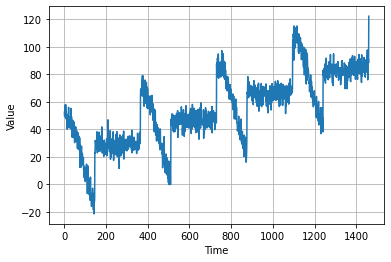

In [5]:
plot_series(time, series)

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series=tf.expand_dims(series, axis=-1)
  dataset=tf.data.Dataset.from_tensor_slices(series)
  dataset=dataset.window(window_size+1, shift=1, drop_remainder=True)
  dataset=dataset.flat_map(lambda window: window.batch(window_size+1))
  dataset=dataset.map(lambda window: (window[:-1], window[-1:]))
  dataset=dataset.shuffle(buffer_size=shuffle_buffer)
  dataset=dataset.batch(batch_size).prefetch(1)

  return dataset

In [7]:
window_size=20
batch_size=32
shuffle_buffer_size=1000

In [8]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

dataset=windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [15]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, 
                         kernel_size=5,
                         strides=1,
                         padding='causal',
                         activation='relu',
                      input_shape=[None,1]),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=500, callbacks=[lr_schedule])

Epoch 1/500
31/31 [==============================] - 59s 13ms/step - loss: 22.5191 - mae: 23.0155 - lr: 1.0000e-08
Epoch 2/500
31/31 [==============================] - 1s 12ms/step - loss: 22.4020 - mae: 22.8987 - lr: 1.1220e-08
Epoch 3/500
31/31 [==============================] - 1s 12ms/step - loss: 22.2581 - mae: 22.7554 - lr: 1.2589e-08
Epoch 4/500
31/31 [==============================] - 1s 12ms/step - loss: 22.0920 - mae: 22.5891 - lr: 1.4125e-08
Epoch 5/500
31/31 [==============================] - 1s 12ms/step - loss: 21.8982 - mae: 22.3951 - lr: 1.5849e-08
Epoch 6/500
31/31 [==============================] - 1s 12ms/step - loss: 21.6727 - mae: 22.1691 - lr: 1.7783e-08
Epoch 7/500
31/31 [==============================] - 1s 12ms/step - loss: 21.4050 - mae: 21.9011 - lr: 1.9953e-08
Epoch 8/500
31/31 [==============================] - 1s 13ms/step - loss: 21.0846 - mae: 21.5808 - lr: 2.2387e-08
Epoch 9/500
31/31 [==============================] - 1s 12ms/step - loss: 20.6959 - mae

(1e-08, 0.0001, 0.0, 30.0)

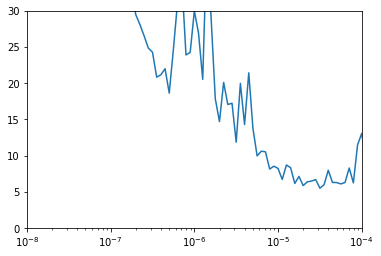

In [14]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

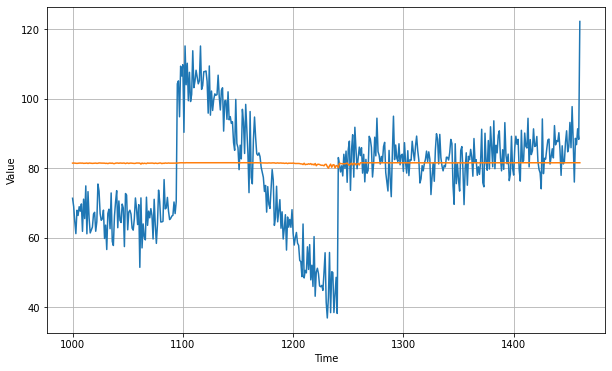

In [23]:
forecast=[]
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)